In [ ]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import trange, tqdm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr

# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the data
fatigue_df = pd.read_csv('/content/drive/MyDrive/Datasets/Carbon_Torsion_UC.csv')
fatigue_df

,Heat,Stress (Mpa),Number of Cycles,Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu
0,1,320,28100,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02
1,1,320,32100,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02
2,1,310,90400,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02
3,1,310,119000,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02
4,1,300,263000,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,36,320,88300,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11
374,36,310,117000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11
375,36,300,144000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11
376,36,300,321000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11


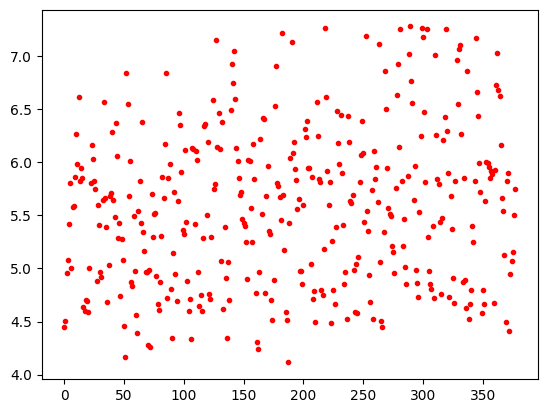

In [ ]:
# Scatter Plot for the Target Column
plt.plot(np.log10(fatigue_df['Number of Cycles']), 'r.')

# # Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

In [ ]:
# Remove columns that are not needed
drop_cols = ['Heat','Number of Cycles'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (Mpa),Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu
0,360,550,825,0.10,0.03,0.01,33,22,63,0.44,0.24,0.82,0.021,0.021,0.03,0.02,0.02
1,320,550,610,0.07,0.00,0.03,33,21,62,0.26,0.23,0.51,0.018,0.024,0.01,0.02,0.01
2,350,550,1270,0.12,0.01,0.00,33,22,66,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02
3,290,600,1270,0.07,0.02,0.00,33,27,72,0.25,0.18,0.44,0.009,0.017,0.08,0.12,0.08
4,280,600,1270,0.07,0.02,0.00,33,27,72,0.25,0.18,0.44,0.009,0.017,0.08,0.12,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,360,550,660,0.06,0.00,0.00,33,55,79,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11
374,310,600,1270,0.08,0.01,0.00,33,22,60,0.54,0.26,0.76,0.022,0.021,0.02,0.12,0.01
375,290,600,825,0.10,0.03,0.01,33,25,66,0.44,0.24,0.82,0.021,0.021,0.03,0.02,0.02
376,350,550,660,0.06,0.00,0.00,33,55,79,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11


In [ ]:
# Convert the features into floats
features = features.astype('float64')

In [ ]:
# Custom dataset class for handling features and labels
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.features = data
        self.labels = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]

        return feature, label

  0%|          | 0/3000 [00:00<?, ?it/s]

Run # 1 Fold # 1


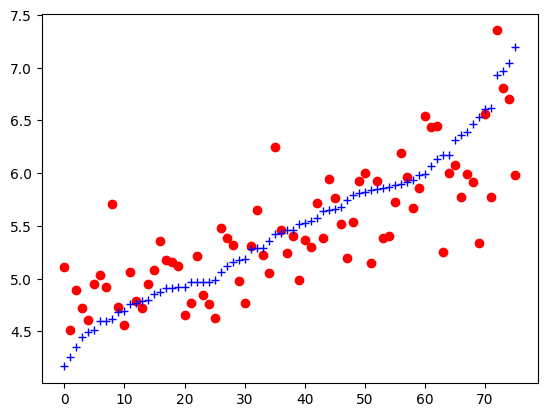

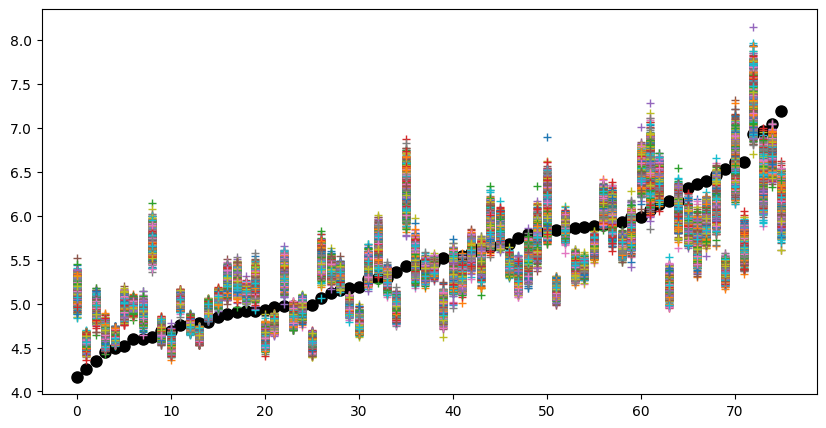

Pearson CC: 0.7915358215433778
R2 score: 0.6243489878751143
RMSE: 0.43223491311073303
MAE: 0.3377600610256195
MAPE: 0.0
Coverage: 26.315789473684212
Upper coverage: 63.15789473684212
Lower coverage: 63.15789473684212
Average Interval Width: 0.3547358810901642
Median Interval Width: 0.31885385513305664
Composite Metric: 0.9814266846595616


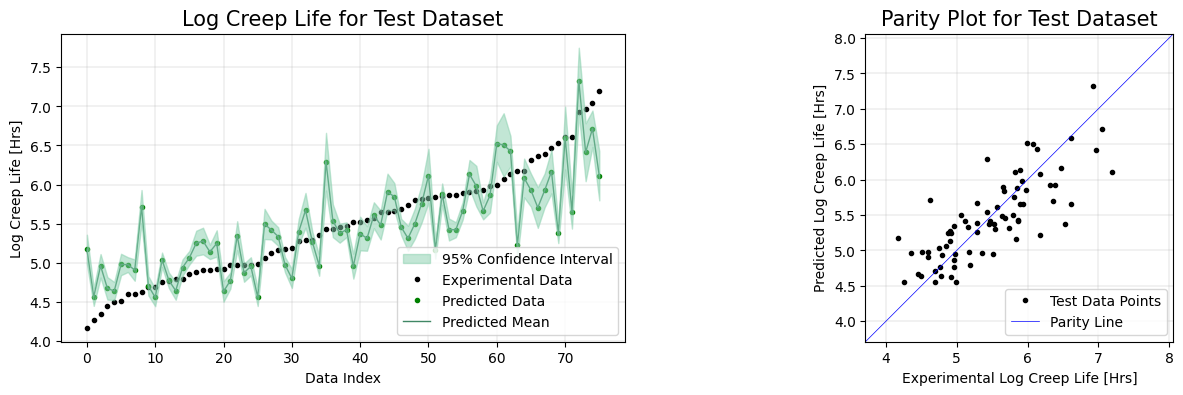

****************************************


  0%|          | 0/3000 [00:00<?, ?it/s]

Run # 1 Fold # 2


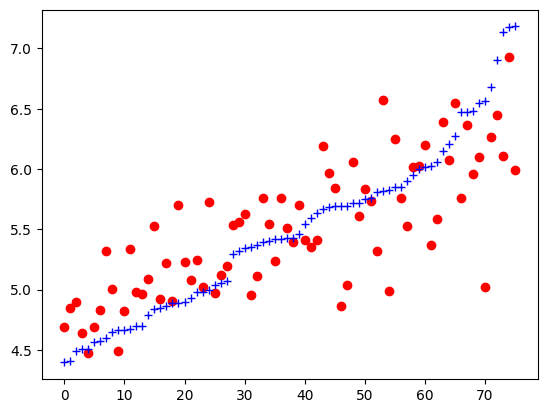

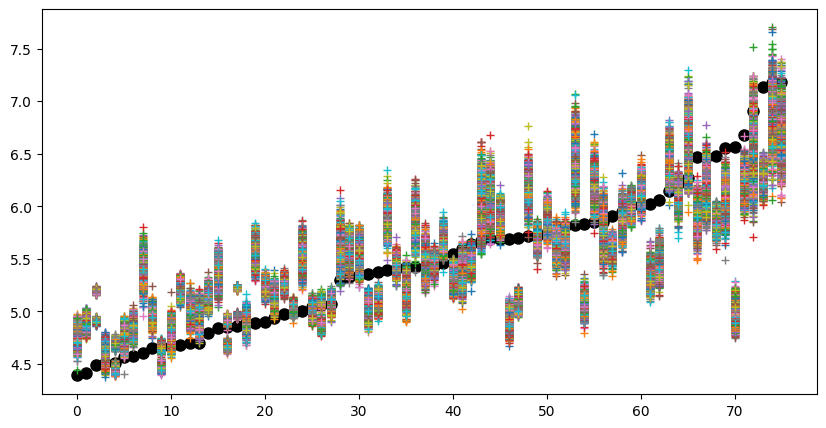

Pearson CC: 0.8064499245382106
R2 score: 0.6490719550879763
RMSE: 0.41608211398124695
MAE: 0.32930028438568115
MAPE: 0.0
Coverage: 35.526315789473685
Upper coverage: 63.15789473684212
Lower coverage: 72.36842105263158
Average Interval Width: 0.40391525626182556
Median Interval Width: 0.35465240478515625
Composite Metric: 0.9713629325815345


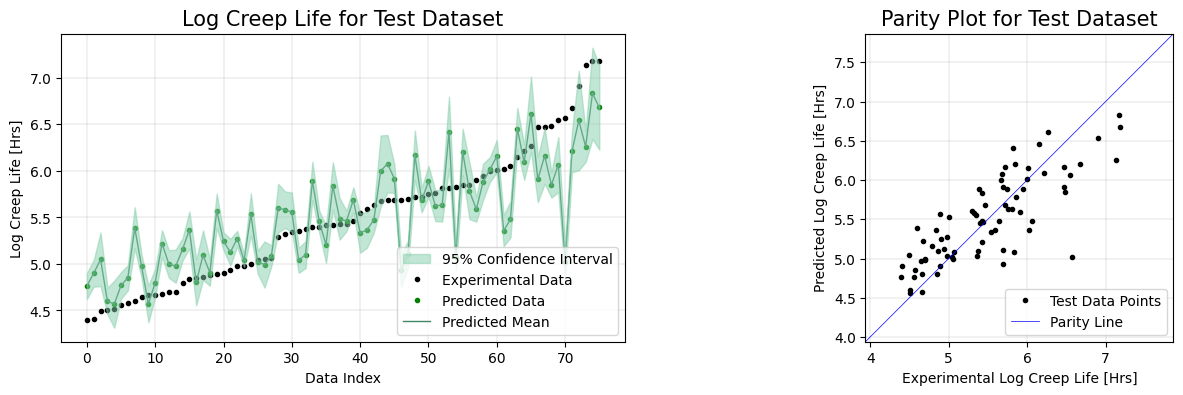

****************************************


  0%|          | 0/3000 [00:00<?, ?it/s]

Run # 1 Fold # 3


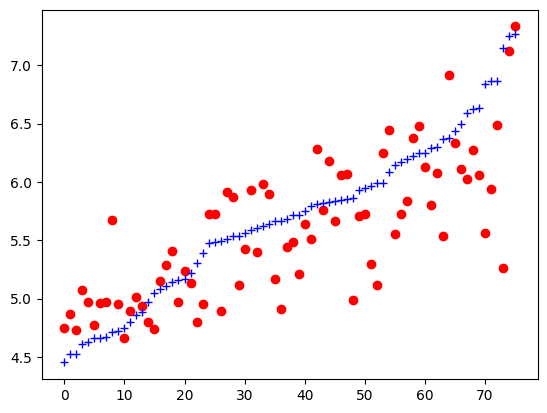

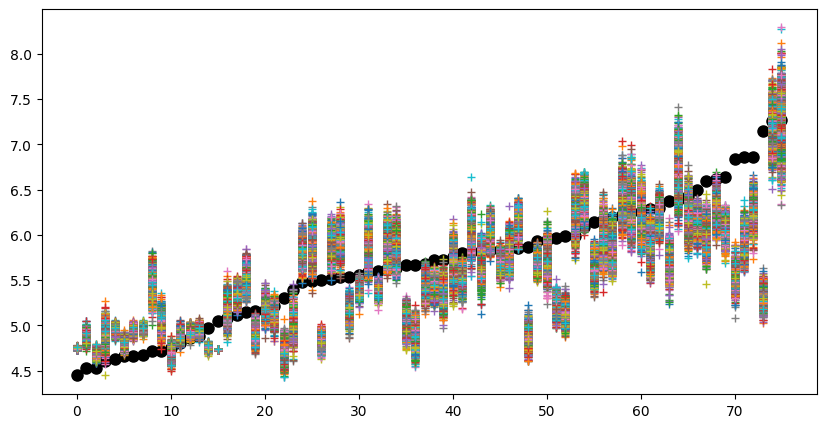

Pearson CC: 0.7764572725958607
R2 score: 0.5615816073238333
RMSE: 0.46015411615371704
MAE: 0.3524450361728668
MAPE: 0.0
Coverage: 31.578947368421055
Upper coverage: 73.68421052631578
Lower coverage: 57.894736842105274
Average Interval Width: 0.4050898849964142
Median Interval Width: 0.4008054733276367
Composite Metric: 0.8605860824209712


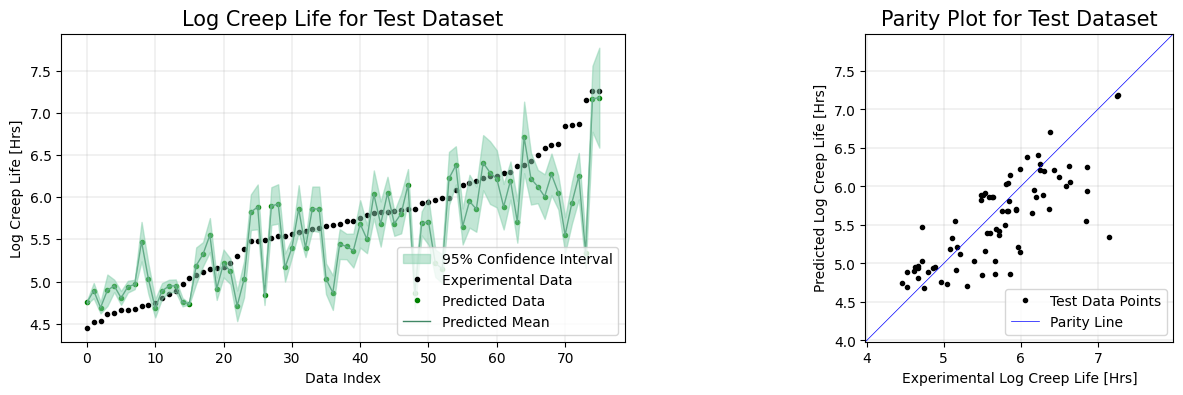

****************************************


  0%|          | 0/3000 [00:00<?, ?it/s]

Run # 1 Fold # 4


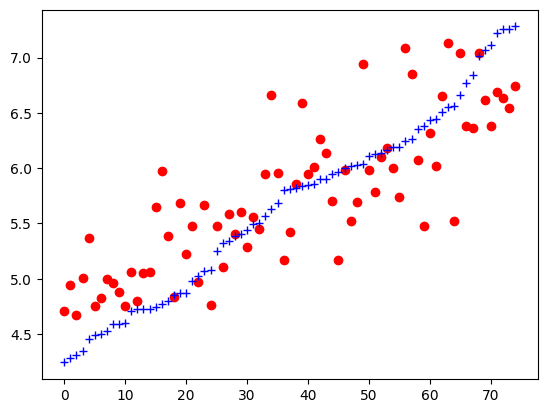

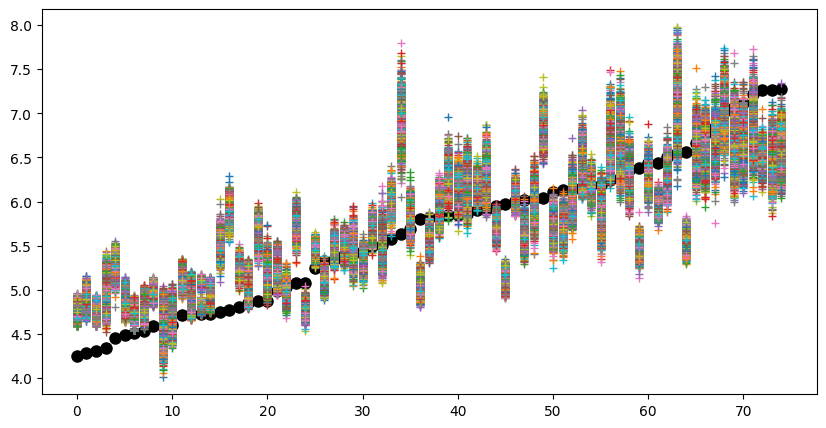

Pearson CC: 0.8399846440137368
R2 score: 0.6969831030246629
RMSE: 0.46598175168037415
MAE: 0.37075045704841614
MAPE: 0.0
Coverage: 45.33333333333333
Upper coverage: 66.66666666666666
Lower coverage: 78.66666666666666
Average Interval Width: 0.5412158370018005
Median Interval Width: 0.4765739440917969
Composite Metric: 0.8645775668168829


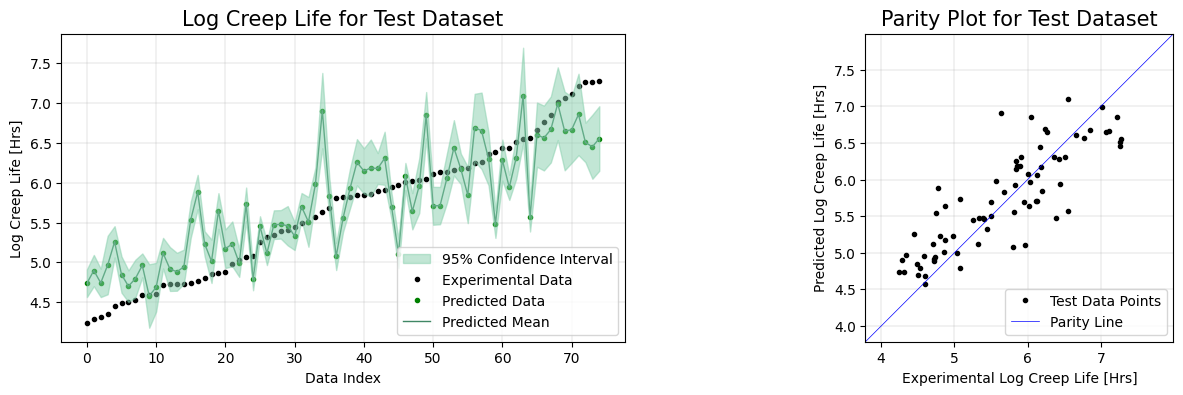

****************************************


  0%|          | 0/3000 [00:00<?, ?it/s]

Run # 1 Fold # 5


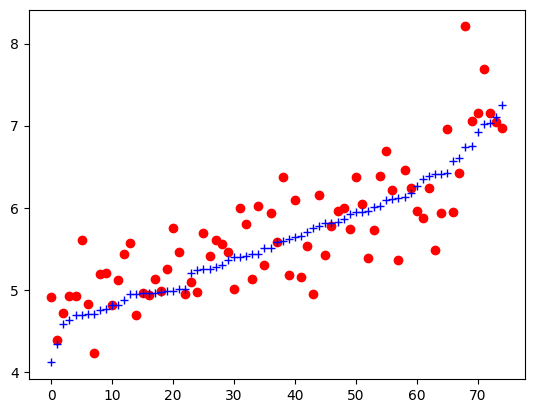

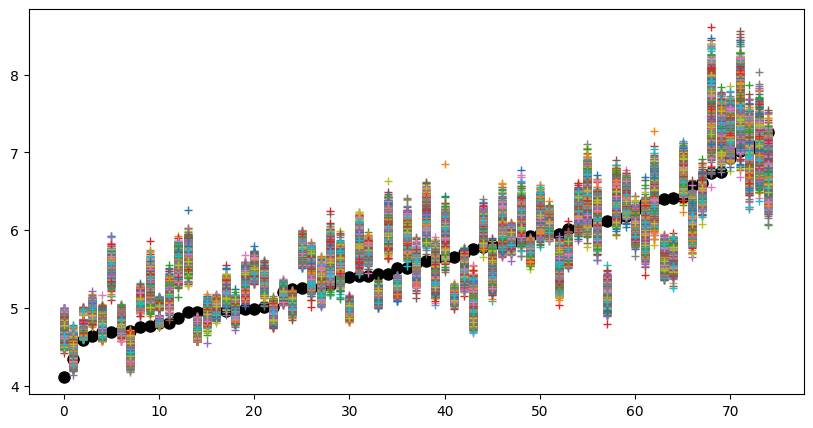

Pearson CC: 0.8565252886016006
R2 score: 0.6985478677524954
RMSE: 0.3939484655857086
MAE: 0.3257831037044525
MAPE: 0.0
Coverage: 38.66666666666667
Upper coverage: 64.0
Lower coverage: 74.66666666666666
Average Interval Width: 0.4889530539512634
Median Interval Width: 0.4384899139404297
Composite Metric: 0.8601385415080798


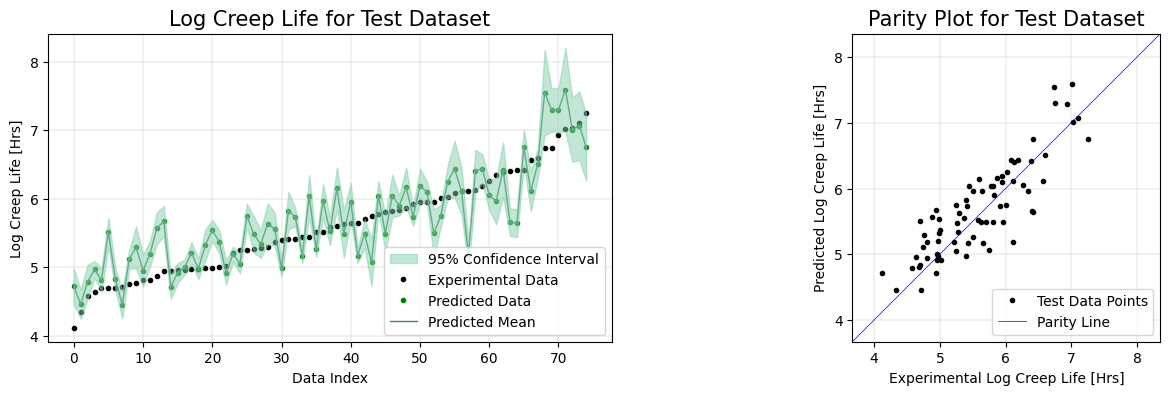

****************************************


In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=50+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            x_train = x_train.astype(dtype=np.float32)
            x_test = x_test.astype(np.float32)
            y_train_np = y_train.to_numpy(dtype=np.float32)
            y_test_np =  y_test.to_numpy(dtype=np.float32)

            x_train = torch.from_numpy(x_train)
            y_train = torch.from_numpy(y_train_np)

            x_test = torch.from_numpy(x_test)
            y_test = torch.from_numpy(y_test_np)

            train_dataset = MyDataset(x_train, y_train)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)

            # define DNN
            class MLP(nn.Module):
                def __init__(self, input_dim=17, output_dim=1, hidden_dim=10, n_hidden_layers=1, use_dropout=False):
                    super().__init__()

                    self.use_dropout = use_dropout
                    if use_dropout:
                        self.dropout = nn.Dropout(p=0.5)
                    self.activation = nn.ReLU()

                    # dynamically define architecture
                    self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
                    layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                                range(1, len(self.layer_sizes))]
                    self.layers = nn.ModuleList(layer_list)

                def forward(self, input):
                    hidden = self.activation(self.layers[0](input))
                    for layer in self.layers[1:-1]:
                        hidden_temp = self.activation(layer(hidden))

                        if self.use_dropout:
                            hidden_temp = self.dropout(hidden_temp)

                        hidden = hidden_temp + hidden  # residual connection

                    output_mean = self.layers[-1](hidden).squeeze()
                    return output_mean

            def train(net, x_train, y_train):
                optimizer = torch.optim.Adagrad(params=net.parameters(), lr=0.01)
                criterion = nn.MSELoss()

                progress_bar = trange(3000)
                for _ in progress_bar:
                    for i, data in enumerate(train_dataloader):
                        traning_data, training_label = data
                        optimizer.zero_grad()
                        y_pred = net(torch.Tensor(traning_data))
                        loss = criterion(y_pred.squeeze(), torch.Tensor(training_label))
                        progress_bar.set_postfix(loss=f'{loss / features.shape[0]:.3f}')
                        loss.backward()
                        optimizer.step()
                return net

            # training
            net_dropout = MLP(hidden_dim=100, n_hidden_layers=3, use_dropout=True)
            net_dropout = train(net_dropout, x_train, y_train)

            print('Run #', j+1, "Fold #", i+1)
            y_pred_test = net_dropout(x_test)
            plt.plot(y_pred_test.detach().numpy(), 'ro', y_test, 'b+')
            plt.show()

            # inference
            n_dropout_samples = 1000

            # compute predictions
            y_preds = [net_dropout(x_test).clone().detach().numpy() for _ in range(n_dropout_samples)]
            y_preds = np.array(y_preds)

            # Plot the predictions
            fig, ax = plt.subplots(figsize=(10, 5))
            iteration_list = [ i for i in range(len(y_test))]
            ax.plot(iteration_list, y_test, 'ko', markersize=8)
            for idx in range(len(y_preds)):
                        ax.plot(iteration_list, y_preds[idx], '+')
            plt.legend(loc=4, fontsize=15, frameon=False)
            plt.show()

            # Mean and standard deviation
            y_pred = np.mean(y_preds, axis=0)
            y_std = np.std(y_preds, axis=0)
            y_test = y_test.detach().numpy()

            ## Metrics for evaluating the predictive accuracy of the model
            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            print(f'MAPE: {MAPE[j, i]}')

            ## Metrics for evaluating the uncertainty quantification of the model
            # Coverage
            def coverage(y, yL, yH):
                  return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

            df_test_low = y_pred - 2*y_std
            df_test_mean = y_pred
            df_test_high = y_pred + 2*y_std

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)
            upper_coverage[j, i] = coverage(y_test, df_test_low, np.inf)
            lower_coverage[j, i] = coverage(y_test, -np.inf, df_test_high)
            print(f'Coverage: {test_coverage[j, i]}')
            print(f'Upper coverage: {upper_coverage[j, i]}')
            print(f'Lower coverage: {lower_coverage[j, i]}')

            # Prediction interval width
            mean_interval_width[j, i] = np.mean(df_test_high - df_test_low)
            print(f'Average Interval Width: {mean_interval_width[j, i]}')
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')

            ## Parity Plot
            # find the boundaries of y_test and y_pred values
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            ax[1].plot(y_test, y_pred, 'ko', markersize=3, label="Test Data Points")
            ax[1].legend(loc=4, fontsize=10, frameon=False)
            ax[1].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            ax[1].legend(loc=4, fontsize=10, frameon=True)
            ax[1].set_xlabel("Experimental Log Creep Life [Hrs]", fontsize=10)
            ax[1].set_ylabel("Predicted Log Creep Life [Hrs]", fontsize=10)
            ax[1].set_title("Parity Plot for Test Dataset", fontsize=15)
            ax[1].grid(True, which='major', linestyle='-', linewidth='0.25')
            ax[1].set_xlim(bounds)
            ax[1].set_ylim(bounds)
            ax[1].set_aspect("equal", adjustable="box") # Square aspect ratio

            plt.show()
            print(40*'*')

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.791536,0.624349,0.432235,0.337760
1,0.806450,0.649072,0.416082,0.329300
2,0.776457,0.561582,0.460154,0.352445
3,0.839985,0.696983,0.465982,0.370750
4,0.856525,0.698548,0.393948,0.325783


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
MAPE_mean = np.mean(MAPE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
MAPE_std = np.std(MAPE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'MAPE Mean': MAPE_mean, 'MAPE Std': MAPE_std,},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,MAPE Mean,MAPE Std
0,0.814191,0.029848,0.646107,0.050922,0.43368,0.026962,0.343208,0.016557,0.0,0.0


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Upper Coverage': upper_coverage.flatten(), 'Lower Coverage': lower_coverage.flatten(),
                    'Mean Interval Width': mean_interval_width.flatten(), 'Median Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Upper Coverage,Lower Coverage,Mean Interval Width,Median Interval Width,Composite Metric
0,26.315789,63.157895,63.157895,0.354736,0.318854,0.981427
1,35.526316,63.157895,72.368421,0.403915,0.354652,0.971363
2,31.578947,73.684211,57.894737,0.405090,0.400805,0.860586
3,45.333333,66.666667,78.666667,0.541216,0.476574,0.864578
4,38.666667,64.000000,74.666667,0.488953,0.438490,0.860139


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
upper_coverage_mean = np.mean(upper_coverage)
lower_coverage_mean = np.mean(lower_coverage)
mean_interval_width_mean = np.mean(mean_interval_width)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
upper_coverage_std = np.std(upper_coverage)
lower_coverage_std = np.std(lower_coverage)
mean_interval_width_std = np.std(mean_interval_width)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 'Upper Coverage Mean': upper_coverage_mean, 'Upper Coverage Std': upper_coverage_std,
                  'Lower Coverage Mean': lower_coverage_mean, 'Lower Coverage Std': lower_coverage_std,
                    'Mean Interval Width Mean': mean_interval_width_mean, 'Mean Interval Width Std':mean_interval_width_std,
                    'Median Interval Width Mean': median_interval_width_mean, 'Median Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Upper Coverage Mean,Upper Coverage Std,Lower Coverage Mean,Lower Coverage Std,Mean Interval Width Mean,Mean Interval Width Std,Median Interval Width Mean,Median Interval Width Std,Composite Metric Mean,Composite Metric Std
0,35.484211,6.425668,66.133333,3.988929,69.350877,7.664768,0.438782,0.066969,0.397875,0.056505,0.907618,0.056267
